In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC



#### Variables
. (SEQ) – sequence number, unique identifier for observations 
 
II. Original HMDA data 
A.  Loan Information 
1. (S3) Type of Loan 
Codes: 
1 – Conventional 
3.    (S4) Purpose of Loan 
Codes: 
1 – Home purchase 
2 – Home improvement 
3 – Refinancing 
4 – Multifamily 
       4.    ( S5) Occupancy 
Codes: 
1 – Owner-occupied 
2 – Not owner-occupied 
3 – Not applicable 
5.    (S6) Loan amount (in thousands) 
6.    (S7) Type of action taken 
Codes: 
1 – Loan originated 
2 – Application approved but not accepted 
                 by applicant 
3 – Application denied 
4 – Application withdrawn 
5 – File closed for incompleteness 
6 – Loan purchased by institution 
 
B. Property Location:  
1.  (S9) MSA (Boston Metropolitan Statistical Area) number where property 
located 
2.  (S11) County where property located 
  Codes: 
  1 – Suffolk 
  0 – Other 
   
 
C. Applicant Information 
1.  (S13) Applicant race 
Codes: 
1 – American Indian or Alaskan Native 
2 – Asian or Pacific Islander 
3 – Black 
4 – Hispanic 
5 – White 
6 – Other 
7 – Information not provided by applicant in 
                mail or telephone application 
8 – Not applicable 
2.    (S14) Co-applicant race
* 
3.    (S15) Applicant sex 
Codes: 
1 – Male 
2 – Female 
3 – Information not provided by applicant in 
                mail or telephone application 
4 – Not applicable 
4.    (S16) Co-applicant sex
* 
5.    (S17) Applicant income (in thousands) 
 
D. Other Loan Information  
1.    (S18) Type of purchaser of loan 
Codes: 
0 – Loan was not sold in calendar year covered by register 
1 – FNMA 
2 – GNMA 
3 – FHLMC 
4 – FMHA  
5 – Commercial bank 
6 – Savings bank or savings association 
7 – Life insurance company 
8 – Affiliate institution 
9 – Other type of purchaser 
2.    (S19A) Original HMDA report, reasons for denial 
Codes: 
1 – Debt-to-income ratio 
2 – Employment history 
3 – Credit history 
4 – Collateral 
5 – Insufficient cash 
6 – Unverifiable information 
7 – Credit application incomplete 
8 – Mortgage insurance denied 
9 – Other 
                                                 
* Same codes as preceding variable 
 
 
III. Follow-up Survey Data 
1.  (S19B, S19C, S19D)  Additions or corrections to reasons for denial from 
Boston survey data* 
2.    (S20) Number of units in property purchased 
3.    (S23A) Marital status of applicant 
Codes: 
M – Married 
U – Unmarried (includes single, divorced and widowed) 
S – Separated 
4.    (S24A) Number of dependents claimed by applicant 
5.  (S25A) Years employed in applicable line of work 
6. (S26A) Years employed on applicable job 
7. (S27A) Self-employed applicant 
Codes: 
0 – Not self-employed 
1 – Self-employed 
8. (S30A) Base employment monthly income of applicant (in dollars) 
9. (S30C) Base employment monthly income of coapplicant (in dollars) 
10. (S31A) Total monthly income of applicant (in dollars) 
11. (S31C) Total monthly income of coapplicant (in dollars) 
12. (S32) Proposed monthly housing expense (in dollars) 
13. (S33) Purchase price (in thousands) 
14. (S34) Other financing (in thousands) 
15. (S35) Liquid assets (in thousands)
** 
16. (S39) Number of commercial credit reports in loan file 
17. (S40) Applicants' credit history meets loan policy guidelines for approval 
Codes: 
0 – No 
1 – Yes 
18. (S41) Number of separate consumer credit lines on credit reports 
19. (S42) Credit history - mortgage payments 
Codes:   
    1 – No late mortgage payments 
2 – No mortgage payment history 
   3 – One or two late mortgage payments 
4 – More than two late mortgage payments 
20. (S43) Credit history - consumer payments 
Codes: 
1 – No "slow pay" or delinquent accounts, but sufficient references for 
determination 
2 – One or two "slow pay" account(s) (each with one or two payments 30 
days past due) 
3 – More than two "slow pay" accounts (each with one or two payments 
30 days past due); or one or two chronic "slow pay" account(s) (with 
three or more payments 30 days past due in any 12-month period) 
4 – Insufficient credit history or references for determination 
                                                 
* Same codes as preceding variable 
** Applicant and coapplicant data were summed if separate statements were completed. 
5 – Delinquent credit history (containing account(s) with a history of 
payments 60 days past due) 
6 – Serious delinquencies (containing account(s) with a history of 
payments 90 days past due) 
21. (S44)  Credit history - public records 
0 – Information not considered 
0 – No public record defaults 
1 – Bankruptcy 
1 – Bankruptcy and
 charge offs 
1 – One or two charge-off(s), public record(s), or collection action(s), 
totaling less than $300 
1 – Charge-off(s), public record(s), or collection action(s) totaling more 
than $300 
22. (S45) Debt-to-income ratio (the banks’ calculation of housing 
expense/income) 
23. (S46) Debt-to-income ratio (the banks’ calculation of total 
obligations/income) 
24. (S47) Fixed or adjustable rate loan (F or A) 
Codes: 
1 – Adjustable 
2 – Fixed 
3 – Not Available 
25. (S48) Term of loan (months) 
26. (S49) Special loan application program 
27. (S50) Appraised value (in thousands) 
28. (S51)  Type of property purchased 
Codes: 
1 – Condominium 
2 – Single family 
3 – 2 to 4 families 
29. (S52) Private mortgage insurance (PMI) sought?   
Codes: 
0 – No or information not available 
1 – Yes 
30. (S53) Private mortgage insurance (PMI) denied? 
Codes: 
0 – PMI approved, did not apply, or information not available 
1 – PMI sought and denied 
31. (S54) Was a gift or grant as part of down payment? 
Codes: 
0 – No or information not available 
1 – Yes 
32. (S55) Was there a co-signer for the application? 
Codes: 
0 – No or information not available 
1 – Yes 
33. (S56) Unverifiable information 
Codes: 
0 – Not applicable (all verifiable) 
1 – Some information unverifiable 
34. (S57) Number of times application was reviewed by underwriter 
    
 
 
 
 III. Variables Added for Analysis, taken from the Census Survey    
1. (netw) Net worth (Total assets - Total liabilities)
*** 
2. (uria) Probability of unemployment by industry 
3. (rtdum) Minority population share in tract 
Codes: 
0 – if ≤ 0.30 
1 – if > 0.30 
4. (bd) Boarded-up value of tract 
Codes: 
0 – if 
≤ MSA median 
1 – if > MSA median 
5. (mi) Median tract income 
Codes: 
0 – if 
≤ MSA median 
1 – if > MSA median 
6. (old) Applicant age 
Codes: 
0 – if 
≤ MSA median 
1 – if > MSA median 
2 – missing 
7. (vr) Tract vacancy  
Codes: 
0 – if 
≤ MSA median 
1 – if > MSA median 
8. (school) Years of education 
9. (chvalc) Change in median value of property in a given tract, 1980-1990 
 
IV. Dummy variables created from HMDA data 
1. (dnotown)  Owner occupied property 
0 – Owner occupied 
1 – Not owner occupied, or information not available 
2. (dprop)  Type of property 
0 – Condominium or single family 
1 – 2-4 families 

In [2]:
# quick summary stats
df = pd.read_csv("hmda.csv",delimiter=",")


df.head(10)

,seq,s3,s4,s5,s6,s7,s9,s11,s13,s14,...,uria,rtdum,bd,mi,old,vr,school,chval,dnotown,dprop
0,2,1,1,1,88,1,1120,0,5,5.0,...,3.9,0,1,1,1,0,15.0,206.7355,0,0
1,3,1,1,1,118,1,1120,0,5,5.0,...,3.2,0,1,1,0,1,18.0,238.4943,0,0
2,7,1,1,1,185,1,1120,0,5,5.0,...,3.2,0,1,1,1,0,12.0,200.1977,0,0
3,9,1,1,1,185,1,1120,0,5,5.0,...,4.3,0,0,1,0,1,12.0,193.8895,0,0
4,10,1,1,1,330,1,1120,0,5,5.0,...,3.2,0,0,1,1,0,20.0,257.0874,0,0
5,11,1,1,1,97,1,1120,0,5,5.0,...,3.9,0,1,1,1,0,16.0,237.8392,0,0
6,12,1,1,1,56,1,1120,0,5,8.0,...,3.9,0,1,1,1,0,14.0,212.4823,0,0
7,14,1,1,1,187,1,1120,0,5,5.0,...,1.8,0,1,1,0,0,16.0,197.7294,0,0
8,15,1,1,1,131,3,1120,0,5,5.0,...,3.1,0,1,1,0,0,12.0,213.4624,0,0
9,20,1,1,1,80,1,1120,0,5,5.0,...,3.9,0,0,1,1,0,16.0,213.9908,0,0


In [3]:
# rename columns


df.rename(columns={'s5':'occupancy','s7':'approved','s11':'county','s13':'race',
                   's15':'sex','s17':'income','s23a':'married','s27a':'self_employed',
                   's33':'purchase_price','s34':'other_financing','s35':'liquid_assets',
                   's40':'credit_history','s42':'chmp','s43':'chcp','s44':'chpr',
                   's45':'debt_to_expense','s46':'di_ratio','s50':'appraisal',
                   's53':'pmi_denied','netw':'net_worth','uria':'unemployment',
                   'school':'education','s56':'unverifiable',
                   's52':'pmi_sought'},inplace=True)

In [4]:
# add dummy values from description

df['approved'] = [0 if X == 3 else 1 for X in df['approved']]
df['race'] = [0 if X == 3 else 1 for X in df['race']]
df['married'] = [1 if X == 'M' else 0 for X in df['married']]
df['sex'] = [1 if X == 1 else 0 for X in df['sex']]
df['credit_history'] = [1 if X == 1 else 0 for X in df['credit_history']]

# drop irrelvant variables
df.drop(['seq','s3','s9','s14','s16','s18','s19a','s19b','s19c','s19d','s20','s48','s49','s54','dprop'],inplace=True,axis=1)




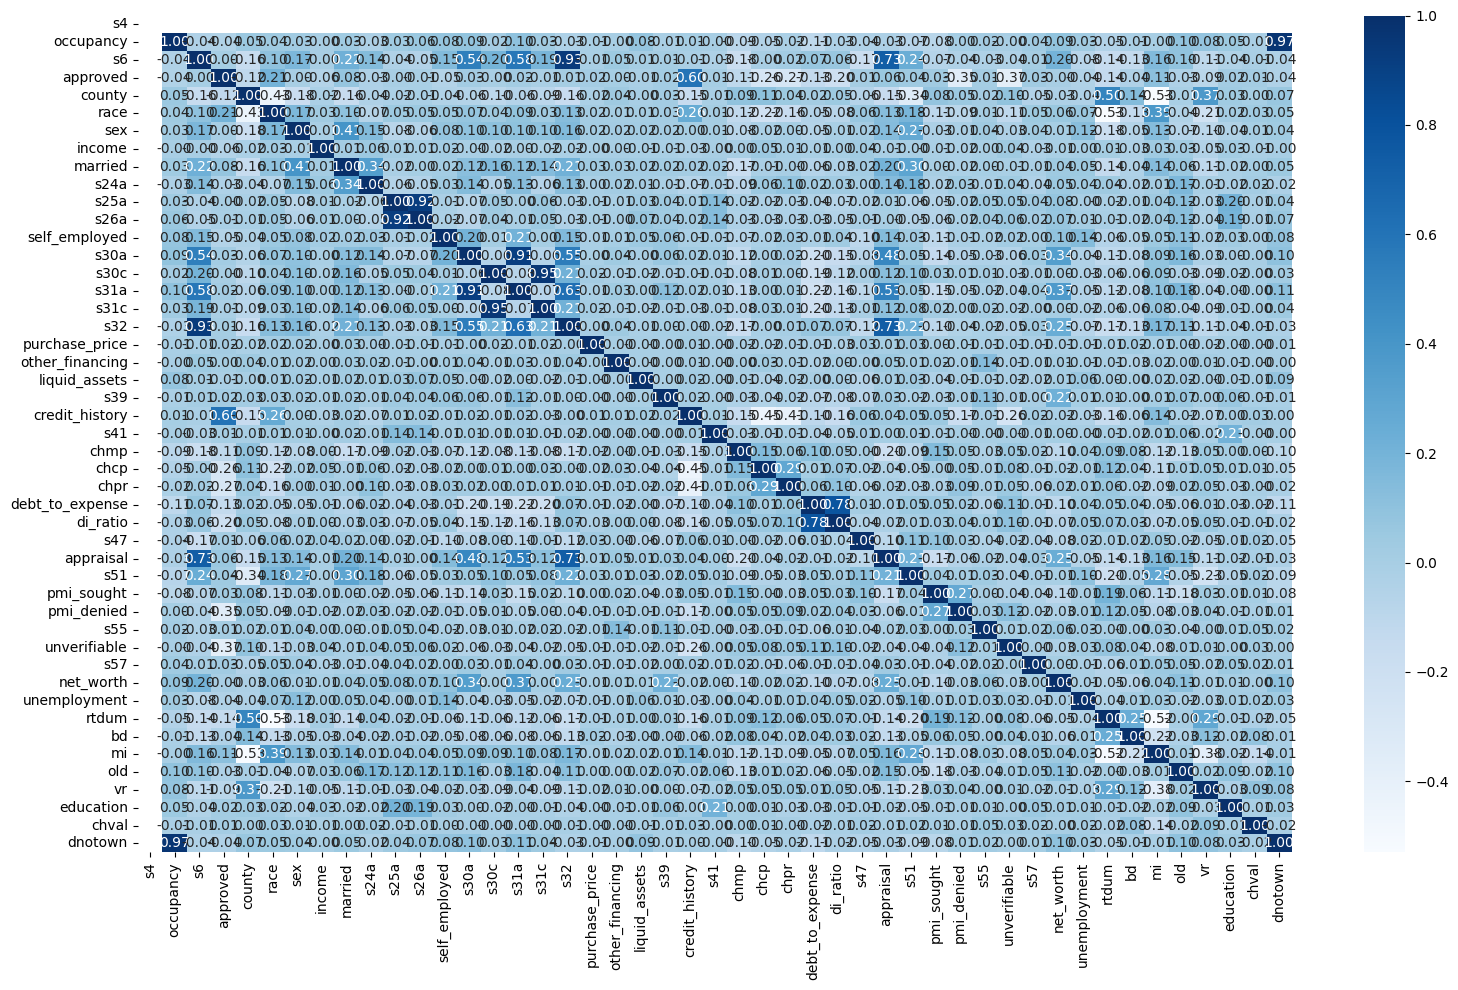

In [5]:
# heatmap

plt.figure(figsize=(16,10))
sns.heatmap(df.corr(),fmt=".2f",annot=True,cmap="Blues")
plt.tight_layout()
plt.savefig("images/heatmap.png")
plt.show()

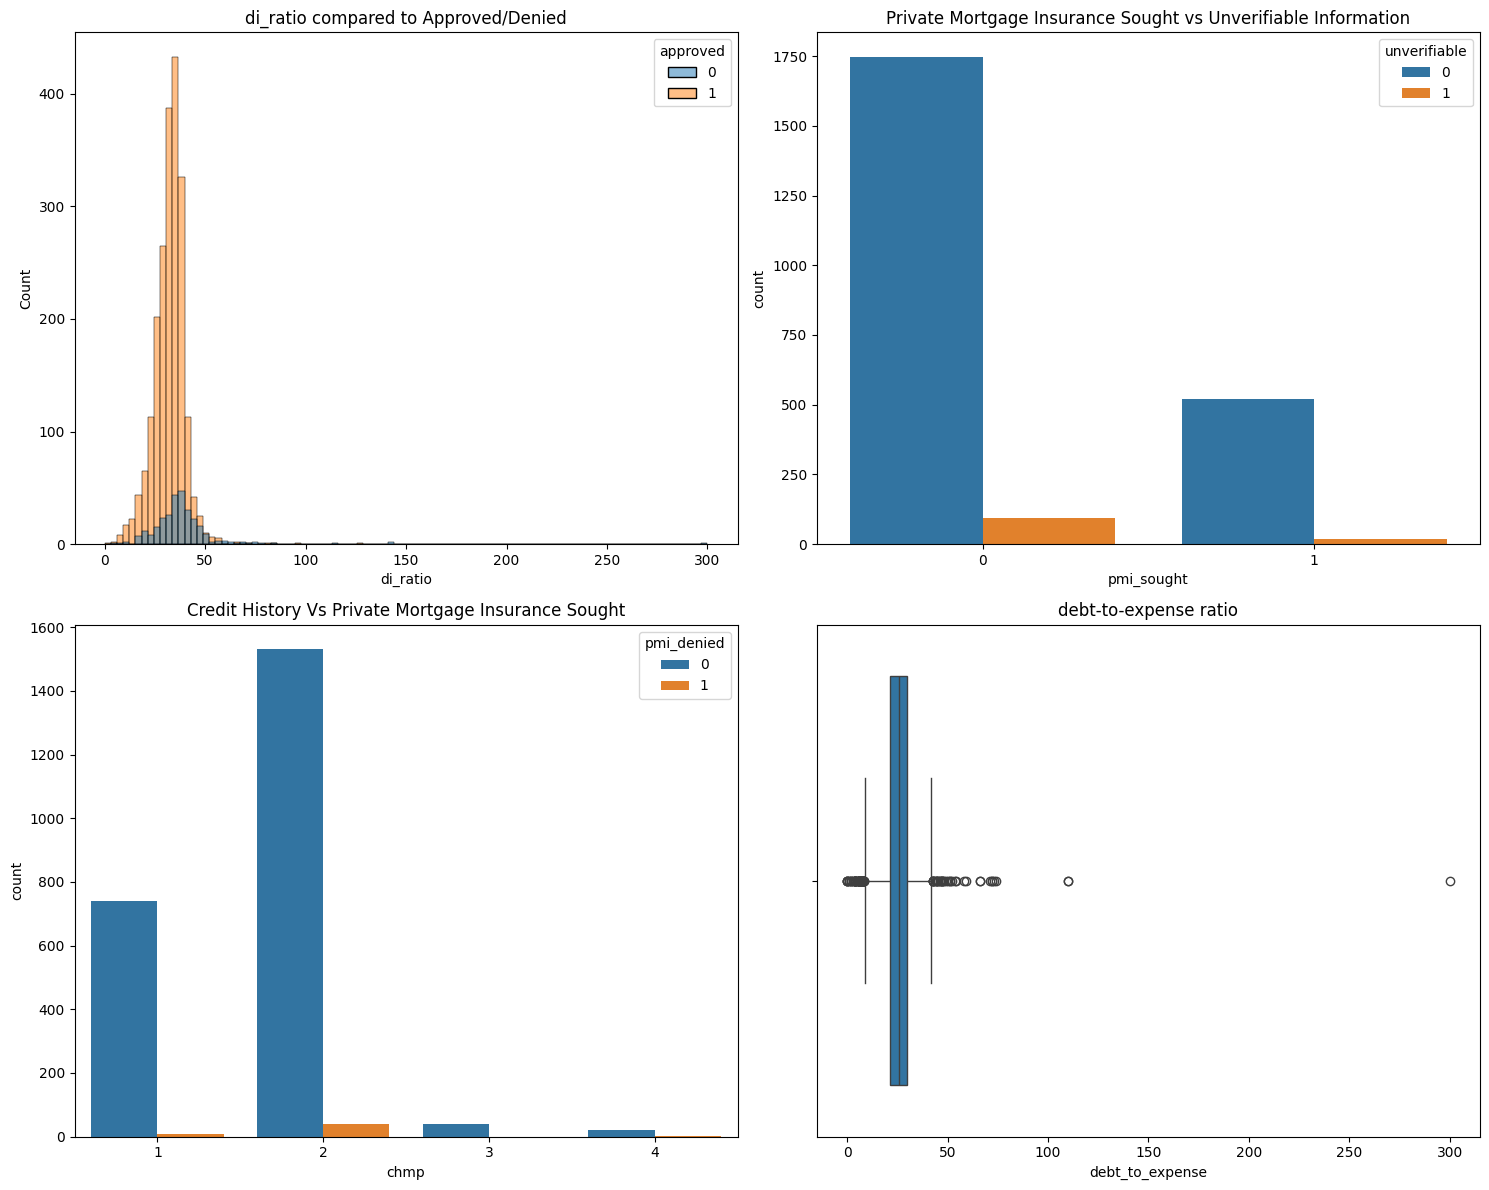

In [6]:
fig,axs = plt.subplots(2,2,figsize=(15,12))

sns.histplot(data=df,ax=axs[0,0],x='di_ratio',hue="approved")
axs[0,0].set_title("di_ratio compared to Approved/Denied")

sns.countplot(data=df,ax=axs[0,1],x='pmi_sought',hue='unverifiable')
axs[0,1].set_title("Private Mortgage Insurance Sought vs Unverifiable Information")

sns.countplot(data=df,ax=axs[1,0],x='chmp',hue='pmi_denied')
axs[1,0].set_title("Credit History Vs Private Mortgage Insurance Sought")

sns.boxplot(data=df,ax=axs[1,1],x='debt_to_expense')
axs[1,1].set_title("debt-to-expense ratio")
plt.tight_layout()
plt.savefig("images/descriptive-stats.png")
plt.show()

In [7]:

selected_features = ['occupancy','race','sex','income','married','credit_history','di_ratio',
                     'pmi_denied','unverifiable','pmi_sought',"vr",'debt_to_expense','chpr','chcp']
X= df[selected_features]
y = df['approved']

olsmodel = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(olsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:               approved   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     162.4
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:11:50   Log-Likelihood:                 101.97
No. Observations:                2380   AIC:                            -173.9
Df Residuals:                    2365   BIC:                            -87.31
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5571      0.042     

In [8]:

# train test split and evaluating each model

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def evaluate(y_test,pred,pred_prob,model_name,cv_scores):


    result = {
        "Model": model_name,
        "Accuracy": acc,
        "RocAucScore": roc,
        "CVscores": cv_scores.mean()
    }

    return result
    


dict_list = []

models = {
    "LogisticRegregression":LogisticRegression(),
    "BaggingClassifier":BaggingClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "xgb":XGBClassifier(objective="binary:logistic")
    }




    
    


for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    pred_prob = model.predict_proba(X_test_scaled)[:,1]
    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_prob)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=4, scoring="roc_auc")
    evaluation_result = evaluate(y_test, pred, pred_prob, model_name, cv_scores)
    dict_list.append(evaluation_result)



df_results = pd.DataFrame(dict_list)


print(df_results)



                        Model  Accuracy  RocAucScore  CVscores
0       LogisticRegregression  0.945378     0.919524  0.916593
1           BaggingClassifier  0.943277     0.888980  0.855917
2      RandomForestClassifier  0.936975     0.907549  0.896092
3  GradientBoostingClassifier  0.936975     0.922686  0.899275
4                         xgb  0.943277     0.904074  0.874958


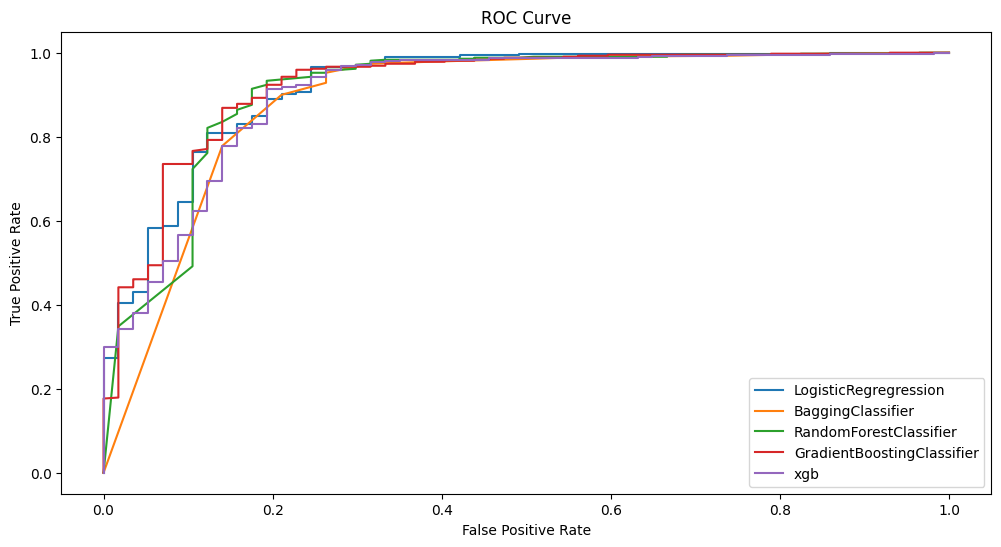

In [9]:
# roc/auc curve

def plot_roc_curve(models,X_test_scaled,y_test):
    plt.figure(figsize=(12,6))
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, pred_prob)
        plt.plot(fpr, tpr, label=model_name)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig("images/roc-cures.png")
    plt.show()



plot_roc_curve(models, X_test_scaled, y_test)

In [10]:
lr_params = {
    'C': [0.001, 0.01, 0.1,1,10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [1000, 5000, 10000]
}



gradient_boosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [1,0.5,0.25,0.1,0.05,0.01],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10],
}

random_forest_params = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_leaf':[1,2,4],
    'max_features': ['sqrt','log2',None],
    "criterion":["gini", "entropy"]
}



svc_params = {
    'C': [0.1,1,10,100,1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

bagging_classifier_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}


knn_params = {
    'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']
               }



xgb_params = {
        'min_child_weight': [1,5,10],
        'gamma': [0.5,1,1.5,2,5],
        'subsample': [0.6,0.8,1.0],
        'colsample_bytree': [0.6,0.8,1.0],
        'max_depth': [3,4,5]
        }
    



models = {
    "LogisticRegression": (LogisticRegression(), lr_params),
    "RandomForestClassifier": (RandomForestClassifier(), random_forest_params),
    "GradientBoostingClassifier": (GradientBoostingClassifier(), gradient_boosting_params),
    "SVC": (SVC(probability=True), svc_params),
    "BaggingClassifier": (BaggingClassifier(), bagging_classifier_params),
    "KnnearestNeighnors":(KNeighborsClassifier(),knn_params),
    "xgboostingclassifier":(XGBClassifier(objective="binary:logistic"),xgb_params)
}


best_score = []


for model_name,(model,params) in models.items():
    print(f'GridSearch For {model_name}:')
    clf = GridSearchCV(model, params,cv=4,scoring="roc_auc",n_jobs=-1).fit(X_train_scaled,y_train)
    print(f'Best Parameters for {model_name} : {clf.best_params_}')
    print(f'Best RocAuc Scores for: {model_name} : {clf.best_score_ * 100:.2f}%')
    best_score.append({"Model":model_name,"RocScore":clf.best_score_})

best_scores_df = pd.DataFrame(best_score)

best_scores_df

GridSearch For LogisticRegression:
Best Parameters for LogisticRegression : {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best RocAuc Scores for: LogisticRegression : 91.70%
GridSearch For RandomForestClassifier:
Best Parameters for RandomForestClassifier : {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
Best RocAuc Scores for: RandomForestClassifier : 90.92%
GridSearch For GradientBoostingClassifier:
Best Parameters for GradientBoostingClassifier : {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best RocAuc Scores for: GradientBoostingClassifier : 90.79%
GridSearch For SVC:
Best Parameters for SVC : {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best RocAuc Scores for: SVC : 90.58%
GridSearch For BaggingClassifier:
Best Parameters for BaggingClassifier : {'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 200}
Best RocAuc Scores for: BaggingClassifier : 88.90%
Gri

,Model,RocScore
0,LogisticRegression,0.916981
1,RandomForestClassifier,0.909245
2,GradientBoostingClassifier,0.907879
3,SVC,0.905791
4,BaggingClassifier,0.888985
5,KnnearestNeighnors,0.893580
6,xgboostingclassifier,0.914762
